# **Import Libraries and modules**

In [1]:
# https://keras.io/


In [1]:
# import dependencies

import os
import shutil

import keras
import numpy as np
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.datasets import mnist
from keras.layers import (Activation, Add, BatchNormalization, Convolution2D,
                          Dense, Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.
/home/pintu/.local/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Load pre-shuffled MNIST data into train and test sets

In [2]:
# load mnist data by keras api
# This does all the preprocessing while loading the data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

(60000, 28, 28)


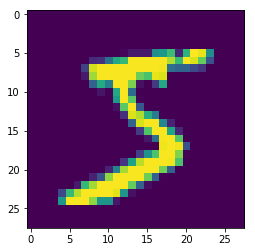

In [3]:
# pyplot is a python package used for plotting of images

print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[0])

In [4]:
# reshaping train and test data to channel last format

X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [5]:
# 32 floating point precision and normalizing 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [6]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [7]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [8]:
Y_train[:10]


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [9]:
# score = model.evaluate(X_test, Y_test, verbose=0)
# print(score)
# y_pred = model.predict(X_test)
# print(y_pred[:9])
# print(y_test[:9])

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
%matplotlib inline
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(X_train[2]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_14'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()

In [10]:
base_dir = os.getcwd()
if os.path.exists(os.path.join(base_dir, 'test_results')):
    shutil.rmtree(os.path.join(base_dir, 'test_results'))
    os.mkdir(os.path.join(base_dir, 'test_results'))
else:
    os.mkdir(os.path.join(base_dir, 'test_results'))


# model checkpoint
filepath="/media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# learning rate schedular
def scheduler(epoch,lr):
    return round(0.003 * 1/(1 + 0.319 * epoch), 10)
lr_sch = LearningRateScheduler(scheduler)

# callback list,should be called from model.fit
callbacks_list = [checkpoint]


# data augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=64)
test_generator = test_gen.flow(X_test, Y_test, batch_size=64)

## 1st code block

This block has the base architecture (no BN, DropOut, LR, larger batch size, change in Optimizer, etc)

total num params 13,546

val_acc becomes 0.99000

In [10]:
# Base architecture (no BN, DropOut, LR, larger batch size, change in Optimizer, etc)
model = Sequential()

# input = 28,28,1, output = 26, 26, 32 , receptive field = 3
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) 

# input =  26, 26, 32 output = 26, 26, 16 , receptive field = 3
model.add(Convolution2D(16,1,activation='relu'))
#receptive field = 6
model.add(MaxPooling2D(pool_size=(2, 2)))

# input =  13, 13, 16 output = 11, 11, 32 , receptive field = 8
model.add(Convolution2D(32, 3, 3, activation='relu'))
# input =  11, 11, 32 output = 11, 11, 16 , receptive field = 8
model.add(Convolution2D(16,1, activation='relu'))
#receptive field = 16
model.add(MaxPooling2D(pool_size=(2, 2)))
# input =  5, 5, 16 output = 3, 3, 32 , receptive field = 18
model.add(Convolution2D(32, 3, 3, activation='relu'))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 16)        528       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv

/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  """
/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  del sys.path[0]
/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`


In [14]:
# loss function is categorical_crossentropy, based on loss function the weights are updated
# metric is used to judge the performance of the model after each epoch. Here we are using categorical_accuracy as metric, 
# before running we need to compile the model
# adam is a optimization algorithm which is used for weight updates


model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr = 0.003),
             metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, nb_epoch=15, verbose=1 , validation_data=(X_test, Y_test),callbacks=callbacks_list)

/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0797 - acc: 0.9749 - val_loss: 0.0512 - val_acc: 0.9839

Epoch 00001: val_acc improved from -inf to 0.98390, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-01-0.9839.hdf5
Epoch 2/15
60000/60000 [==============================] - 5s 87us/step - loss: 0.0532 - acc: 0.9839 - val_loss: 0.0532 - val_acc: 0.9837

Epoch 00002: val_acc did not improve from 0.98390
Epoch 3/15
60000/60000 [==============================] - 5s 83us/step - loss: 0.0435 - acc: 0.9863 - val_loss: 0.0435 - val_acc: 0.9868

Epoch 00003: val_acc improved from 0.98390 to 0.98680, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-03-0.9868.hdf5
Epoch 4/15
60000/60000 [==============================] - 5s 83us/step - loss: 0.0363 - acc: 0.9887 - val_loss: 0.0501 - val_acc: 0.9856

Epoch 00004: val_


Results:
    
So model did not have a accuracy more than 0.99000 

Model is overfitting. So lets add dropout.

# 2nd code block

base architecture + dropout added

adding extra - dropout

total num params 13,546

val_acc becomes 0.99010

In [11]:
# Base architecture (no BN, DropOut, LR, larger batch size, change in Optimizer, etc)
model = Sequential()

# input = 28,28,1, output = 26, 26, 32 , receptive field = 3
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) 
model.add(Dropout(0.1))
# input =  26, 26, 32 output = 26, 26, 16 , receptive field = 3
model.add(Convolution2D(16,1,activation='relu'))
#receptive field = 6
model.add(MaxPooling2D(pool_size=(2, 2)))

# input =  13, 13, 16 output = 11, 11, 32 , receptive field = 8
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(Dropout(0.1))
# input =  11, 11, 32 output = 11, 11, 16 , receptive field = 8
model.add(Convolution2D(16,1, activation='relu'))
#receptive field = 16
model.add(MaxPooling2D(pool_size=(2, 2)))
# input =  5, 5, 16 output = 3, 3, 32 , receptive field = 18
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        528       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)  

/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  """
/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  del sys.path[0]
/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`


In [12]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr = 0.003),
             metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=32, nb_epoch=20, verbose=1 , validation_data=(X_test, Y_test),callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.


/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 127us/step - loss: 0.1923 - acc: 0.9392 - val_loss: 0.0802 - val_acc: 0.9742

Epoch 00001: val_acc improved from -inf to 0.97420, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-01-0.9742.hdf5
Epoch 2/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.0770 - acc: 0.9762 - val_loss: 0.0490 - val_acc: 0.9849

Epoch 00002: val_acc improved from 0.97420 to 0.98490, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-02-0.9849.hdf5
Epoch 3/20
60000/60000 [==============================] - 6s 98us/step - loss: 0.0614 - acc: 0.9813 - val_loss: 0.0444 - val_acc: 0.9869

Epoch 00003: val_acc improved from 0.98490 to 0.98690, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-03-0.9869.hdf5
Epoch 4/20
60000/60000 [=============

Results:

val_acc is 0.99010

Now after adding dropout the overfitting problem is solved

let's add batch norm to increase the accuracy 

# 3rd code block

base network + dropout + Batch norm

adding extra - Batch norm

total num params 14,058(BN adds extra non trainable params,trainable params remain same)

val_acc becomes 0.99290

In [12]:
# Base architecture (no BN, DropOut, LR, larger batch size, change in Optimizer, etc)
model = Sequential()

# input = 28,28,1, output = 26, 26, 32 , receptive field = 3
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) 
model.add(BatchNormalization())
model.add(Dropout(0.1))
# input =  26, 26, 32 output = 26, 26, 16 , receptive field = 3
model.add(Convolution2D(16,1,activation='relu'))
model.add(BatchNormalization())
#receptive field = 6
model.add(MaxPooling2D(pool_size=(2, 2)))

# input =  13, 13, 16 output = 11, 11, 32 , receptive field = 8
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# input =  11, 11, 32 output = 11, 11, 16 , receptive field = 8
model.add(Convolution2D(16,1, activation='relu'))
model.add(BatchNormalization())
#receptive field = 16
model.add(MaxPooling2D(pool_size=(2, 2)))
# input =  5, 5, 16 output = 3, 3, 32 , receptive field = 18
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  """


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
___________________________

/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`


In [13]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr = 0.003),
             metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=32, nb_epoch=15, verbose=1 , validation_data=(X_test, Y_test),callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.


/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 10s 170us/step - loss: 0.1208 - acc: 0.9619 - val_loss: 0.0575 - val_acc: 0.9811

Epoch 00001: val_acc improved from -inf to 0.98110, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-01-0.9811.hdf5
Epoch 2/15
60000/60000 [==============================] - 9s 153us/step - loss: 0.0570 - acc: 0.9823 - val_loss: 0.0385 - val_acc: 0.9873

Epoch 00002: val_acc improved from 0.98110 to 0.98730, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-02-0.9873.hdf5
Epoch 3/15
60000/60000 [==============================] - 9s 152us/step - loss: 0.0477 - acc: 0.9853 - val_loss: 0.0445 - val_acc: 0.9844

Epoch 00003: val_acc did not improve from 0.98730
Epoch 4/15
60000/60000 [==============================] - 9s 156us/step - loss: 0.0421 - acc: 0.9869 - val_loss: 0.0374 - val_acc: 0.9886

Epoch 00004:

Results:

val_acc is 0.99290

total params 14,058

Batch norm incresed acc little bit but lets increase acc more

let's add data augmentation and a bigger batch size to increase the accuracy

# 4th code block

base network + dropout + batch norm + data aug + bigger batch size


adding extra - data aug + bigger batch size

total params 14,058

val acc becomes 0.99265

In [11]:
# Base architecture (no BN, DropOut, LR, larger batch size, change in Optimizer, etc)
model = Sequential()

# input = 28,28,1, output = 26, 26, 32 , receptive field = 3
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) 
model.add(BatchNormalization())
model.add(Dropout(0.1))
# input =  26, 26, 32 output = 26, 26, 16 , receptive field = 3
model.add(Convolution2D(16,1,activation='relu'))
model.add(BatchNormalization())
#receptive field = 6
model.add(MaxPooling2D(pool_size=(2, 2)))

# input =  13, 13, 16 output = 11, 11, 32 , receptive field = 8
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# input =  11, 11, 32 output = 11, 11, 16 , receptive field = 8
model.add(Convolution2D(16,1, activation='relu'))
model.add(BatchNormalization())
#receptive field = 16
model.add(MaxPooling2D(pool_size=(2, 2)))
# input =  5, 5, 16 output = 3, 3, 32 , receptive field = 18
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()


Instructions for updating:
Colocations handled automatically by placer.


/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  """


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  from ipykernel import kernelapp as app
/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
__________

In [13]:
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr = 0.003),
             metrics=['accuracy'])

In [14]:

# # fits the model on batches with real-time data augmentation:
model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=15 ,
                    validation_data=test_generator, validation_steps=10000//64,callbacks=callbacks_list)


Instructions for updating:
Use tf.cast instead.
Epoch 1/15
937/937 [==============================] - 10s 11ms/step - loss: 0.2389 - acc: 0.9251 - val_loss: 0.0548 - val_acc: 0.9804

Epoch 00001: val_acc improved from -inf to 0.98037, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-01-0.9804.hdf5
Epoch 2/15
937/937 [==============================] - 9s 9ms/step - loss: 0.0961 - acc: 0.9699 - val_loss: 0.0428 - val_acc: 0.9877

Epoch 00002: val_acc improved from 0.98037 to 0.98772, saving model to /media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-02-0.9877.hdf5
Epoch 3/15
937/937 [==============================] - 9s 9ms/step - loss: 0.0790 - acc: 0.9759 - val_loss: 0.0407 - val_acc: 0.9860

Epoch 00003: val_acc did not improve from 0.98772
Epoch 4/15
937/937 [==============================] - 9s 9ms/step - loss: 0.0689 - acc: 0.9785 - val_loss: 0.0288 - val_acc: 0.9915

Epoch 00004: val_acc improved from 0.

Results:

val_acc is 0.99265

Doesn't look like accuracy is changed much

now in the last block add learning rate schedular

# 5th block

base network + dropout + batch norm + data aug + bigger batch size + lr_schedular

adding extra - lr_schedular

total params 14,058

val acc becomes 0.99497 after 13th epoch

In [11]:


# Base architecture (no BN, DropOut, LR, larger batch size, change in Optimizer, etc)
model = Sequential()

# input = 28,28,1, output = 26, 26, 32 , receptive field = 3
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(28,28,1))) 
model.add(BatchNormalization())
model.add(Dropout(0.1))
# input =  26, 26, 32 output = 26, 26, 16 , receptive field = 3
model.add(Convolution2D(16,1,activation='relu'))
model.add(BatchNormalization())
#receptive field = 6
model.add(MaxPooling2D(pool_size=(2, 2)))

# input =  13, 13, 16 output = 11, 11, 32 , receptive field = 8
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# input =  11, 11, 32 output = 11, 11, 16 , receptive field = 8
model.add(Convolution2D(16,1, activation='relu'))
model.add(BatchNormalization())
#receptive field = 16
model.add(MaxPooling2D(pool_size=(2, 2)))
# input =  5, 5, 16 output = 3, 3, 32 , receptive field = 18
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr = 0.003),
             metrics=['accuracy'])


# adding learning rate schedular
callbacks_list = [checkpoint,lr_sch]


model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=15 ,
                    validation_data=test_generator, validation_steps=10000//64,callbacks=callbacks_list)


Instructions for updating:
Colocations handled automatically by placer.


/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1...)`
  import sys


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
/home/pintu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        528       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
__________

Results:

val_acc becomes 99.4 after 13th epoch

In [12]:
model = load_model('/media/pintu/BACKUP/extra_projects/EVA/Session4/test_results/weights-improvement-14-0.9950.hdf5')

In [15]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)
y_pred = model.predict(X_test)
# print(y_pred)

[0.016256367067137036, 0.9952]
